## ДЗ Подбор гиперпараметров метода DB_SCAN

Дано:
- дан класс DB_SCAN кластеризации данных
Требуется:
- реализовать эвристический метод побора гиперпараметра eps:

	1. Выберите значение гиперпараметра m. Обычно используются значения от 3 до 9, чем более неоднородный ожидается датасет, и чем больше уровень шума, тем большим следует взять m.

	2. Вычислите среднее расстояние по m ближайшим соседям для каждой точки. Т.е. если m=3, нужно выбрать трёх ближайших соседей, сложить расстояния до них и поделить на три.

	3. Отсортируйте полученные значения по возрастанию и выведите на экран.

	4. Гиперпараметр eps следует взять в полосе, где происходит самый сильный перегиб графика. Чем больше eps, тем больше получатся кластеры, и тем меньше их будет.

- проверить результат подбора параметра eps - показать результат кластеризации для заданного распределение точек при eps меньшим, равным и большим рекомендованного значения
- (не обязательно) попытаться автоматизировать подбор eps согласно эвристики без участия человека  (без построения и анализа графика)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

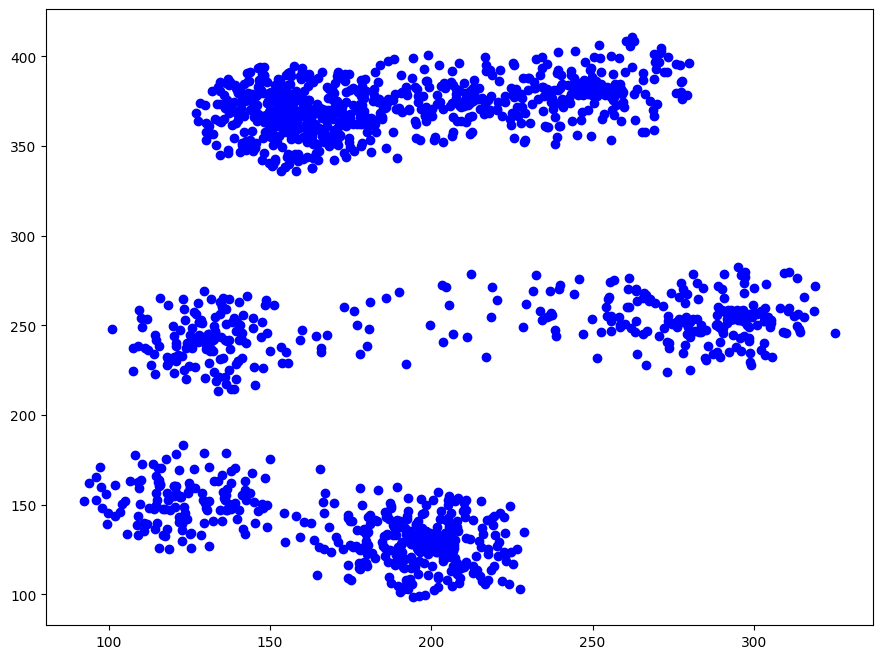

In [47]:
import pygame

points = np.empty((0, 2), dtype='f')

c_radius = 2
c_color = (0, 0, 255)
c_thickness = 0
jet_radius = 30
jet_thr = 0

bg_color = (255, 255, 255)
(width, height) = (640, 480)
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("data generator")

running = True
pushing = False
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            pushing = True
        elif event.type == pygame.MOUSEBUTTONUP:
            pushing = False

    if pushing and np.random.uniform(0, 1) > jet_thr:
        (x, y) = pygame.mouse.get_pos()
        r = np.random.uniform(0, jet_radius)
        phi = np.random.uniform(0, 2 * np.pi)
        coord = [x + r * np.cos(phi), height - y + r * np.sin(phi)]
        points = np.append(points, [coord], axis=0)

    screen.fill(bg_color)
    for point in points:
        pygame.draw.circle(screen, c_color, (int(point[0]), height - int(point[1])), c_radius, c_thickness)
    pygame.display.flip()

pygame.quit()

fig = plt.figure(figsize=(width / 60, height / 60))
plt.scatter(points[:, 0], points[:, 1], c="blue")
plt.show()

In [48]:
class DB_SCAN():

    def __init__(self, dataset, eps=20., min_samples=5):
        self.dataset = dataset
        self.eps = eps
        self.min_samples = min_samples
        self.n_clusters = 0
        self.clusters = {0: []}
        self.visited = []
        self.labels = np.array([], dtype='i')
        self.fitted = False

    def get_dist(self, list1, list2):
        return np.sqrt(sum([(i - j) ** 2 for i, j in zip(list1, list2)]))

    def get_neighbours(self, P):
        return {tuple(Q) for Q in self.dataset if self.get_dist(Q, P) < self.eps}

    def fit(self):
        for P in self.dataset:
            P = list(P)
            if P in self.visited: continue
            self.visited.append(P)
            neighbours = self.get_neighbours(P)
            if len(neighbours) < self.min_samples:
                self.clusters[0].append(P)
            else:
                self.expand_cluster(P)
        self.fitted = True

    def expand_cluster(self, P):
        self.n_clusters += 1
        self.clusters[self.n_clusters] = [P]
        neighbours = self.get_neighbours(P)
        while neighbours:
            Q = list(neighbours.pop())
            if Q in self.visited: continue
            self.visited.append(Q)
            self.clusters[self.n_clusters].append(Q)
            Q_neighbours = self.get_neighbours(Q)
            if len(Q_neighbours) > self.min_samples:
                neighbours = neighbours.union(Q_neighbours)
            if Q in self.clusters[0]: self.clusters[0].remove(Q)

    def get_labels(self):
        if not self.fitted: self.fit()
        labels = []
        for P in self.dataset:
            for i in range(self.n_clusters + 1):
                if list(P) in self.clusters[i]:
                    labels.append(i)
                    break
        self.labels = np.array(labels, dtype='i')
        return self.labels


dbscan = DB_SCAN(points, eps=20., min_samples=4)
dbscan.get_neighbours(dbscan.dataset[123])
labels = dbscan.get_labels()

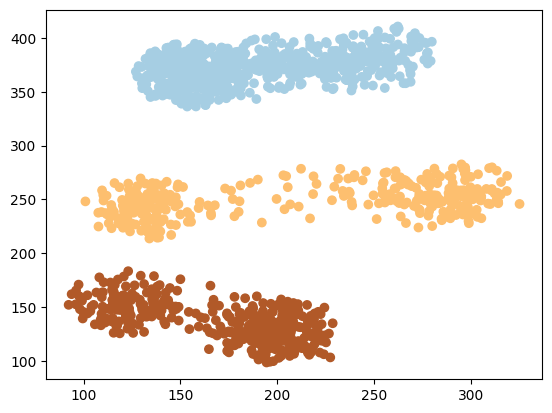

In [49]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=plt.cm.Paired)
plt.show()

In [50]:
def get_dist(list1, list2):
    return np.sqrt(sum((i - j) ** 2 for i, j in zip(list1, list2)))


dists = np.array(
    [[get_dist(point1, point2) for point1 in points if not np.array_equal(point1, point2)] for point2 in points])
dists.sort(axis=1)
m = 5
avg_dists = np.mean(dists[::, 1:m + 1], axis=1)
avg_dists.sort()

print('Средние расстояния до ближайших m соседей: ')
print(avg_dists)

Средние расстояния до ближайших m соседей: 
[ 0.30528123  0.32042496  0.34910752 ... 17.55435866 20.02865343
 20.2160412 ]


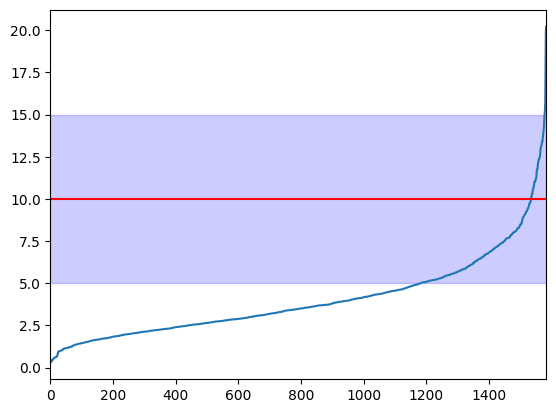

In [52]:
eps = 10
plt.plot(avg_dists)
plt.xlim(0,points.shape[0])
plt.axhline(eps, c='r')
plt.fill_between(np.linspace(0,points.shape[0]),eps - 5, eps + 5, color='b', alpha=0.2)
plt.show()

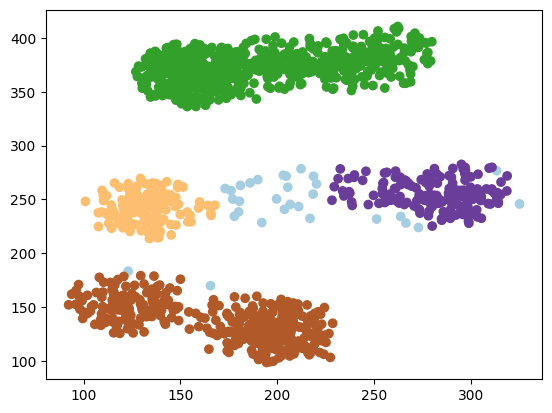

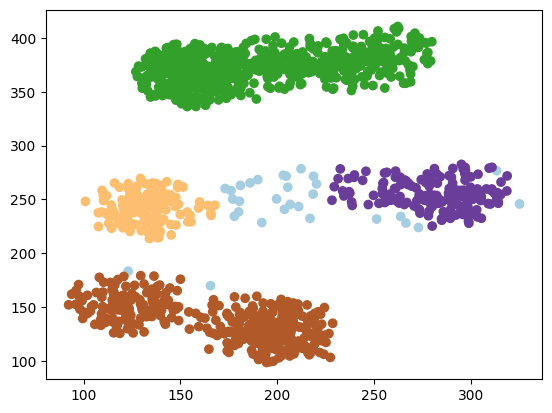

In [54]:
dbscan = DB_SCAN(points, eps=eps, min_samples=m)

labels = dbscan.get_labels()

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

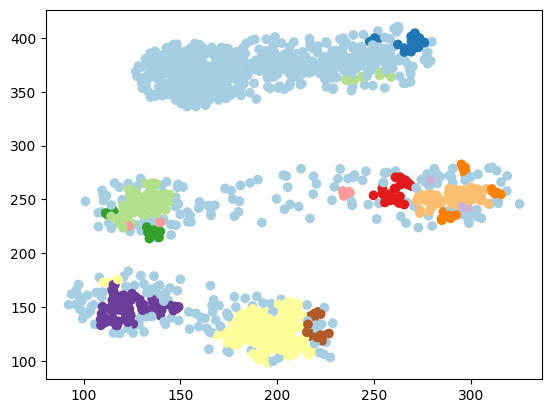

In [55]:
dbscan = DB_SCAN(points, eps=eps / 2, min_samples=m)

labels = dbscan.get_labels()

import matplotlib.pyplot as plt
plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()

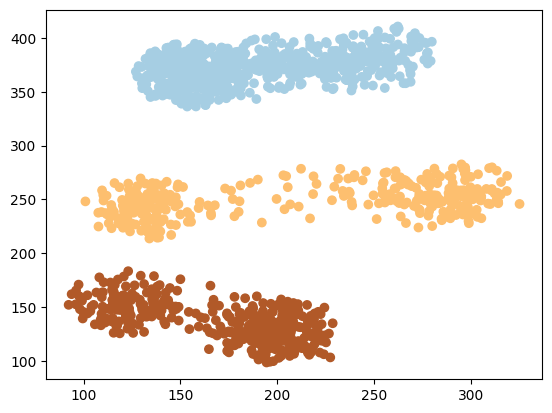

In [56]:
dbscan = DB_SCAN(points, eps=eps * 2, min_samples=m)

labels = dbscan.get_labels()

plt.figure()
plt.scatter(points[:,0], points[:,1], c=labels, cmap=plt.cm.Paired)
plt.show()